### Import libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from scipy.stats import norm

### Customization

In [2]:
# Parameter customization
confidence_level = 90  # e.g., 90 for 90% confidence
forecast_months = 6
forecast_limit= .25 # in decimal or %
my_transaction="0602 inventory_transaction.csv"
my_forecast_file='0602 Forecasted_demand.csv'
my_reorder_file='0602 Inventory_plan.csv'
my_forecast_plot="0602 Forecast.png"
my_reorder_plot="0602 Reorder_Forecast_Plot.png"

### Load and pre-process data

In [3]:
# Load the dataset 
df = pd.read_csv(my_transaction)

# Parse dates safely (drop rows with bad dates) ===
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)

df = df.dropna(subset=['Date'])

#  Clean 'Units Sold' column 
df['Units Sold'] = pd.to_numeric(df['Units Sold'], errors='coerce').fillna(0)

# =Set Date as index 
df.index = df['Date']

# Calculate data horizon and check forecast ratio 
num_unique_days = df.index.nunique()
if forecast_months > 0.25 * num_unique_days:
    print(f"Warning: Forecast period ({forecast_months} months) exceeds 25% of unique data days ({num_unique_days}). This may reduce reliability.\n")

# Resample monthly to get total units sold per month 
df_monthly = df['Units Sold'].resample('MS').sum().reset_index()
df_monthly.columns = ['ds', 'y']  # Prophet requires these names

C:\Users\ahmed\AppData\Local\Temp\ipykernel_35964\4850859.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)


### Fit and forecast demand and reorder level

In [4]:
#  Fit Prophet model 
model = Prophet()
model.fit(df_monthly)

# Forecast specified number of months 
future = model.make_future_dataframe(periods=forecast_months, freq='MS')
forecast = model.predict(future)

# Reorder Plan calculation 
z_value = norm.ppf(0.5 + confidence_level / 200)

forecast_period = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast_months).copy()
forecast_period['std_dev'] = (forecast_period['yhat_upper'] - forecast_period['yhat_lower']) / 4
forecast_period['ReorderPoint'] = forecast_period['yhat'] + z_value * forecast_period['std_dev']
forecast_period['SafetyStock'] = z_value * forecast_period['std_dev']

19:27:40 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing


### Create plots

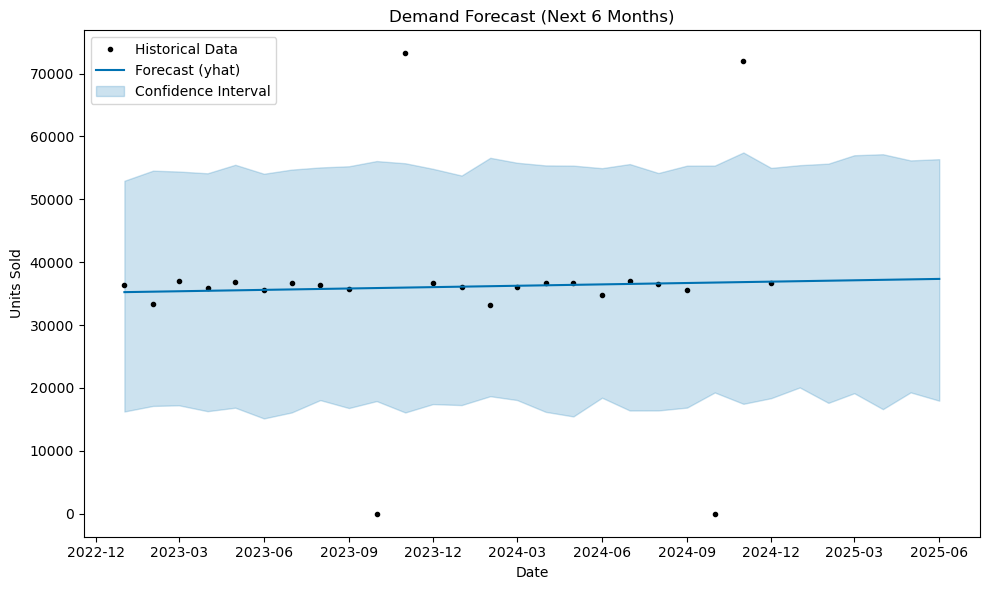

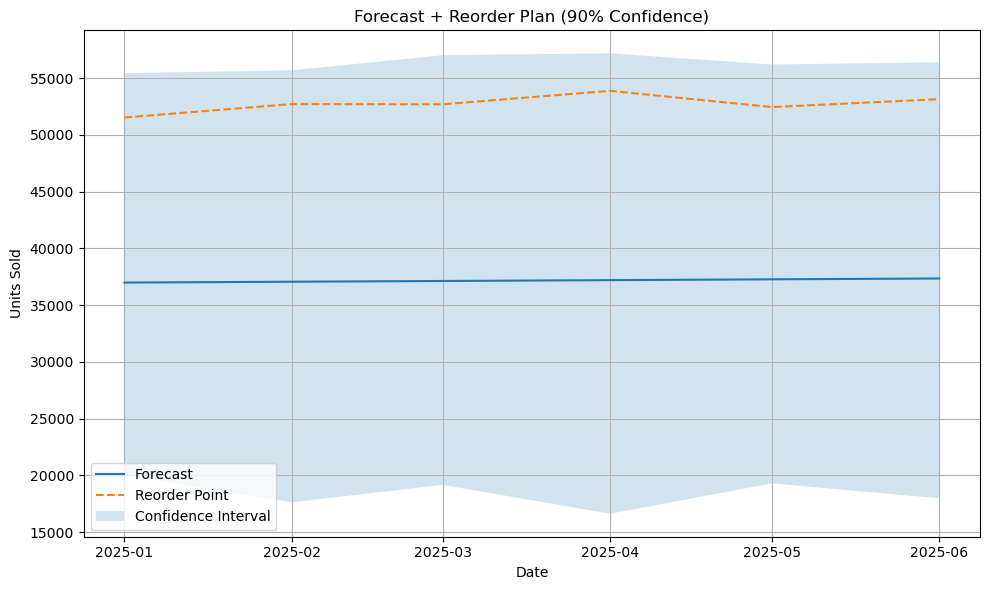

In [5]:
# Prophet default plot with legend 
fig = model.plot(forecast)
ax = fig.gca()

# Manually construct legend
actual_line = ax.lines[0]  # actual data
forecast_line = ax.lines[1]  # forecast (yhat)
lower_bound = ax.collections[0]  # uncertainty interval

labels = ['Historical Data', 'Forecast (yhat)', 'Confidence Interval']
handles = [actual_line, forecast_line, lower_bound]

ax.legend(handles=handles, labels=labels, loc='upper left')
plt.title(f"Demand Forecast (Next {forecast_months} Months)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.grid()
plt.savefig(my_forecast_plot)
plt.show()

# Custom Plot with Reorder Point 
plt.figure(figsize=(10, 6))
plt.plot(forecast_period['ds'], forecast_period['yhat'], label='Forecast')
plt.plot(forecast_period['ds'], forecast_period['ReorderPoint'], linestyle='--', label='Reorder Point')
plt.fill_between(forecast_period['ds'],
                 forecast_period['yhat_lower'],
                 forecast_period['yhat_upper'],
                 alpha=0.2, label='Confidence Interval')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title(f"Forecast + Reorder Plan ({confidence_level}% Confidence)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(my_reorder_plot)
plt.show()

### Save data and plots

In [6]:
# Save forecast and reorder plan 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(my_forecast_file, index=False)
forecast_period.to_csv(my_reorder_file, index=False)

# Display result
print("\nReorder Plan for Next", forecast_months, "Months:")
print(forecast_period[['ds', 'yhat', 'ReorderPoint', 'SafetyStock']])

print("\nForecasting completed and files saved:")
print(f"  • Full Forecast: {my_forecast_file}")
print(f"  • Reorder Plan CSV: {my_reorder_file}")
print("  • Plots saved as PNG files")



Reorder Plan for Next 6 Months:
           ds          yhat  ReorderPoint   SafetyStock
24 2025-01-01  36981.655008  51520.375840  14538.720832
25 2025-02-01  37055.578359  52702.863286  15647.284927
26 2025-03-01  37122.347837  52685.326694  15562.978857
27 2025-04-01  37196.271187  53871.075505  16674.804317
28 2025-05-01  37267.809913  52439.731061  15171.921148
29 2025-06-01  37341.733264  53137.639474  15795.906211

Forecasting completed and files saved:
  • Full Forecast: 0602 Forecasted_demand.csv
  • Reorder Plan CSV: 0602 Inventory_plan.csv
  • Plots saved as PNG files
